In [1]:
import numpy as np

%matplotlib inline

## Required

- `bruges`
- `welly`

## Coordinate transformation in `bruges`

The idea is that you have UTM coordinates of three unique inline, crossline locations in a seismic survey (e.g. three cornerpoints). Once you have provided these, you can look up the (x,y) location of any (inline, xline) location, or vice versa.

In [2]:
import bruges

Define the cornerpoints:

In [3]:
# UTM coords of 3 unique inline, crossline locations.
corners_xy = np.array([[600938.125, 6073394.5],
                       [631226.3125, 6074241.0],
                       [630720.25, 6092358.5]])

# The inline, crossline locations you just provided.
corners_ix = np.array([[99,  104],
                       [99, 1316],
                       [824,1316]])

The `CoordTransform` class provides a function, which we'll call `transform`.

In [4]:
transform = bruges.transform.CoordTransform(corners_ix, corners_xy)

In [5]:
transform([440, 763])   # Or, equivalently, transform.forward([440, 763])

# Should be [617167, 6082379]

array([ 617168.67831747, 6082376.23932798])

We can also go back, from (x, y) to (inline, crossline). 

In [6]:
transform.reverse([617167, 6082379])

array([440, 763])

(If you *only* wanted the reverse function, you could also just have passed the coordinate arrays in to the instantiation in reverse order.)

## Dealing with the vertical axis: no velocity model

To get the seismic sample belonging to a particular depth, we need a velocity model.

If you already have an average velocity model in depth, then you can just look up the velocity and convert it directly.

But let's assume you only have a sonic well log for velocity information...

In [7]:
from welly import Well

w = Well.from_las("data/F03-04.las")

In [8]:
w.data

{'CALI': Curve([ nan,  nan,  nan, ...,  nan,  nan,  nan]),
 'DRHO': Curve([ nan,  nan,  nan, ...,  nan,  nan,  nan]),
 'DT': Curve([ nan,  nan,  nan, ...,  nan,  nan,  nan]),
 'GR': Curve([ nan,  nan,  nan, ...,  nan,  nan,  nan]),
 'ILD': Curve([ nan,  nan,  nan, ...,  nan,  nan,  nan]),
 'LLD': Curve([ nan,  nan,  nan, ...,  nan,  nan,  nan]),
 'LLS': Curve([ nan,  nan,  nan, ...,  nan,  nan,  nan]),
 'MSFL': Curve([ nan,  nan,  nan, ...,  nan,  nan,  nan]),
 'NPHI': Curve([ nan,  nan,  nan, ...,  nan,  nan,  nan]),
 'RHOB': Curve([ nan,  nan,  nan, ...,  nan,  nan,  nan]),
 'SN': Curve([ nan,  nan,  nan, ...,  nan,  nan,  nan]),
 'SP': Curve([ nan,  nan,  nan, ...,  nan,  nan,  nan])}

In [9]:
dt = w.data['DT']

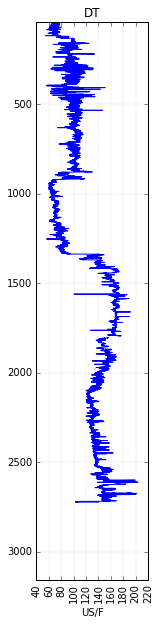

In [10]:
dt.plot()

In [11]:
dt.units

'US/F'

In [12]:
dt

Curve([ nan,  nan,  nan, ...,  nan,  nan,  nan])

In [13]:
# Correct for feet and microseconds.
vp = 0.3048 * 1e6 / dt

In [14]:
vp.start

38.0

In [15]:
vp.interpolate()

Curve([ 4107.10488721,  4107.10488721,  4107.10488721, ...,  2178.11774128,
        2178.11774128,  2178.11774128])

In [16]:
vp = vp.to_basis(start=0).extrapolate()

In [17]:
vp = vp.despike().smooth(20)

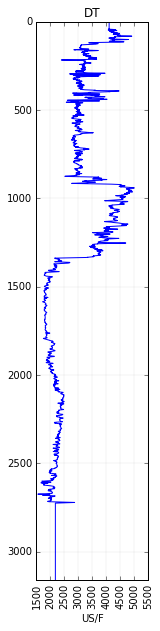

In [18]:
vp.plot()

In [19]:
vp

Curve([ 4107.10488721,  4107.10488721,  4107.10488721, ...,  2178.11774128,
        2178.11774128,  2178.11774128])

Get Vp log in time:

In [22]:
import bruges

In [23]:
dt = 0.004   # seconds seismic sample interval
vp_t = bruges.transform.depth_to_time(vp, vmodel=vp, dt=dt, dz=vp.step, mode='linear')
vp_t.shape

(581,)

It's too short (must match seismic trace), so pad it:

In [24]:
vp_t = np.pad(vp_t, pad_width=[0, 1000-vp_t.size], mode='edge')

Make a random trace and use time-based model to convert it to depth:

In [25]:
tr = np.random.randn(1000)
dz = 0.5   # Depth sample interval
tr_z = bruges.transform.time_to_depth(tr, vmodel=vp_t, dt=dt, dz=dz, mode="linear")

Make a basis for the seismic in depth:

In [26]:
basis = np.linspace(0, tr_z.size*dz, tr_z.size+1)

In [27]:
basis

array([  0.00000000e+00,   5.00000000e-01,   1.00000000e+00, ...,
         4.57450000e+03,   4.57500000e+03,   4.57550000e+03])

This basis gives the depths in 0.5 m intervals. To get the seismic sample at a particluar depth, get it from tr_z, which is the seismic amplitude in depth (i.e. the same basis).